# Test des modeles de segmentation et classification sur le nouveau dataset
Au prealable, on a selectionne 723 images non redondantes avec le dataset initial depuis le jeu de donnees COVIDNET
On conserve les sources actmed, fig1, cohen


In [106]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
%matplotlib inline
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler



In [107]:
# Import des donnees 

path = r"C:\Users\Inrae\Documents\Projet_Data_Science\COVID_NET\SELECT"
dim=256
final_size=(dim, dim)

# Import des données on sépare entre apprentissage et validation
batch_size=32
size=final_size

# Nombre de donnes max par categorie
size_max_cat = None



## Import des fichiers

In [108]:
def getData(X_shape, N = None):
    im_array = []
    target_array = []

    for cat in ["Normal", "COVID"]:       
        image_path = os.path.join(path,cat)
        target = cat
        files = os.listdir(image_path)
        random.Random(1337).shuffle(files)
        
        if (N is None):
            N = len(files)
        else:
            N = min(N, len(files))
        for i in files[:N]: 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            target=cat
            im_array.append(im)
            target_array.append(target)
            
    images = np.array(im_array).reshape(len(im_array),dim,dim,1)
    return images, target_array


In [109]:
# Importing data
dim = 256
images, labels = getData(dim,N=size_max_cat)

print("dataset size : images", images.shape, "labels", len(labels))


dataset size : images (723, 256, 256, 1) labels 723


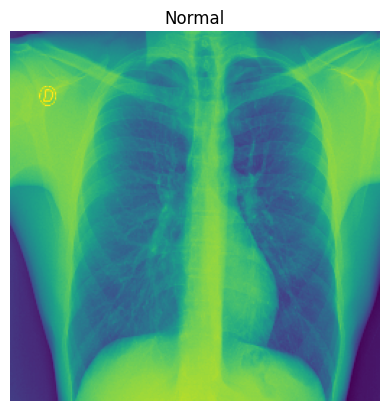

In [110]:
# On verifie que l'import s'est bien passé
i=3

plt.imshow(images[3])
plt.axis("off")
plt.title(labels[3])
plt.show()

## Segmentation : Génération des masques

In [111]:
# Fonction pour definir le modele

def unet(input_size=(dim,dim,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])




In [112]:
# Creation du modele et import des poids
model = unet(input_size=(256,256,1))
model.load_weights("cxr_reg_weights.best.hdf5")
model.compile(optimizer='adam', loss='binary_crossentropy')

In [114]:
# Mise en forme des images

images_scaled = (images-127)/127

print("Shape de image_scaled: ", images_scaled.shape)

# On fait un data_generator

#datagen = ImageDataGenerator() 

# Augmenter respectivement les jeu de données d'entrainement
dataset = datagen.flow(images_scaled, labels, batch_size = 16, shuffle=False)

# On predit sur dataset
masks = model.predict(dataset)

# On convertit en 0-255
masks2 = masks
masks2[masks2>0.5] = 255
masks2[masks2<=0.5] = 0



Shape de image_scaled:  (723, 256, 256, 1)


# Application du modèle de classification

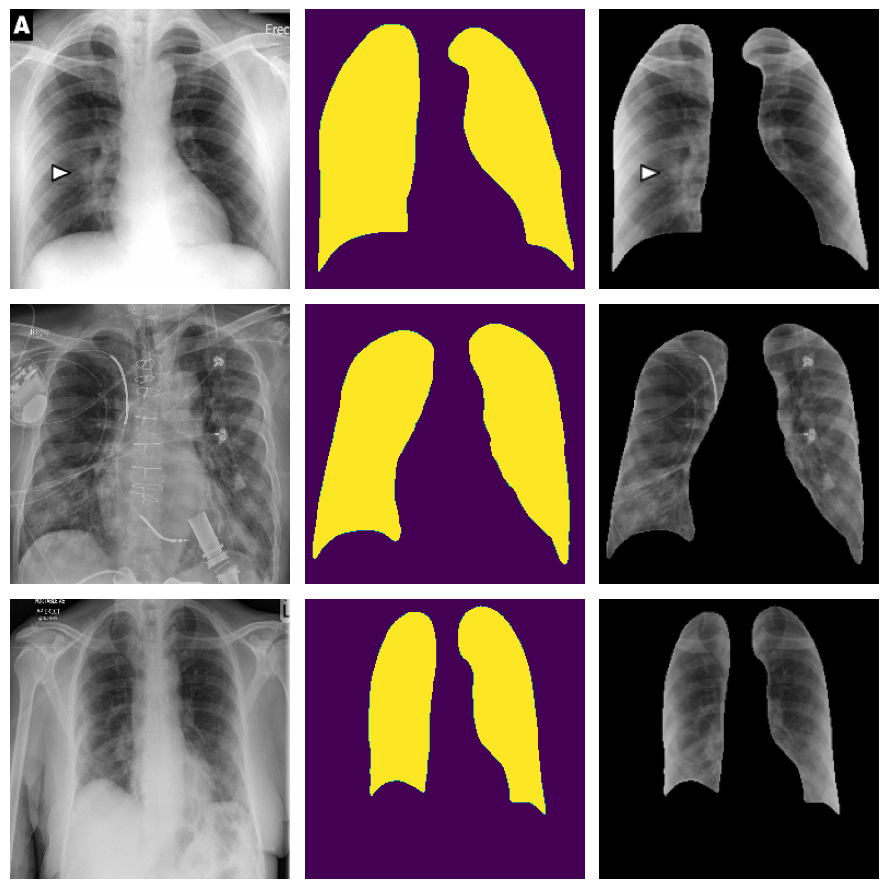

In [150]:
# Preparation des donnees, on masque les images
masked_image_array=[]

for i in range(images.shape[0]) : 
    img = images[i]
    msk = masks2[i].astype(img.dtype)
    masked_image = cv2.bitwise_and(img, msk)
    masked_image = cv2.resize(masked_image, dsize = (224, 224))
    masked_image = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)
    masked_image_array.append(masked_image)

masked_images = np.array(masked_image_array).reshape(len(masked_image_array),224,224,3)

import random
import matplotlib.pyplot as plt

# On trace le graph pour 3 images

fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for i in range(0, 9, 3):
    j = random.randint(0, len(labels)-1)
    
    axs[i//3, 0].imshow(images[j], cmap='gray')
    axs[i//3, 0].set_xlabel("Base Image")
    axs[i//3, 0].axis("off")
   
    axs[i//3, 1].imshow(masks2[j])
    axs[i//3, 1].set_xlabel("Predicted Mask")
    axs[i//3, 1].axis("off")
    
    axs[i//3, 2].imshow(masked_images[j])
    axs[i//3, 2].set_xlabel("Masked Images")
    axs[i//3, 2].axis("off")

plt.tight_layout()
plt.show()



Test avec le modele CHO

In [ ]:
# On prepare le datagenerator

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

clf_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    ) 

clf_dataset = clf_datagen.flow(masked_images, batch_size = 8, shuffle=False)

clf_model = model = tf.keras.models.load_model("../models/model_resnet50_CHO_v1")


In [139]:
print("tailles fichiers images:", masked_images.shape, "taille de labels : ", len(labels))

# On fait les predictions

labels_pred = clf_model.predict(clf_dataset)

tailles fichiers images: (723, 224, 224, 3) taille de labels :  723


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(labels_pred, axis=1).astype("str")

y_pred[y_pred == '0'] = "COVID"
y_pred[y_pred == '1'] = "Lung_Opacity"
y_pred[y_pred == '2'] = "Normal"
y_pred[y_pred == '3'] = "Viral Pneumonia"

# On reconvertit labels covid en 1, normal en 3 selon le dataset initial
y_true = np.array(labels)
y_true[y_true == 'COVID'] = "Positive"
y_true[y_true == 'Normal'] = "Negative"

# On fait la matrice de confusion
pd.crosstab(y_true,y_pred, normalize=0)


col_0,COVID,Lung_Opacity,Normal,Viral Pneumonia
row_0,,,,
Negati,0.381188,0.282178,0.334158,0.002475
Positi,0.695925,0.150470,0.141066,0.012539


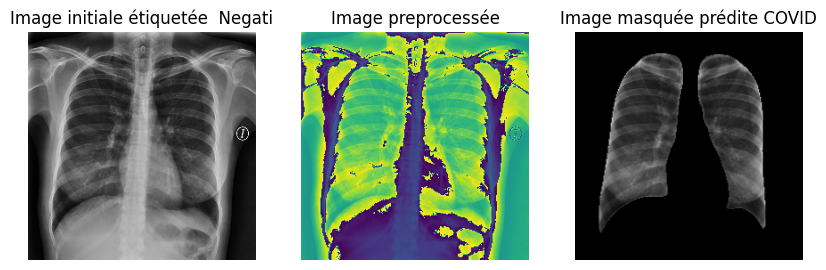

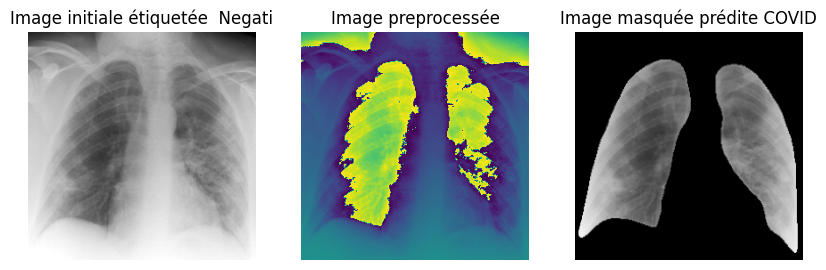

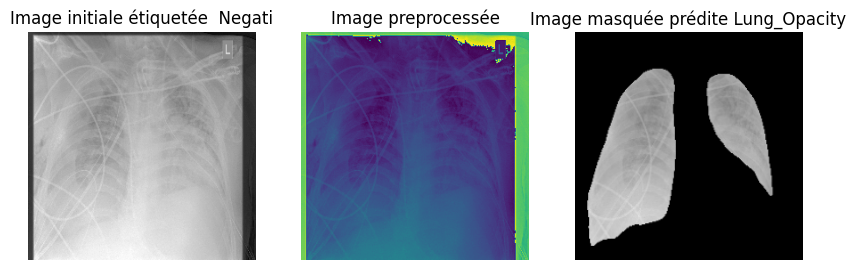

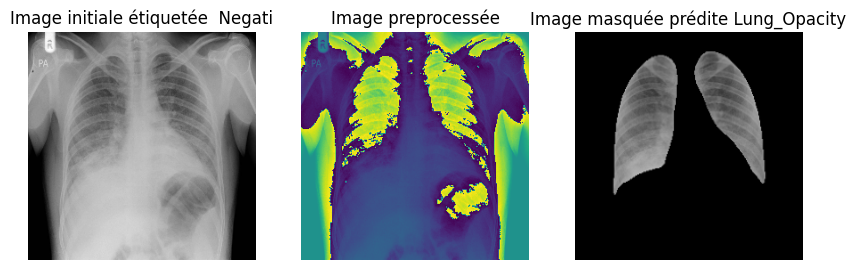

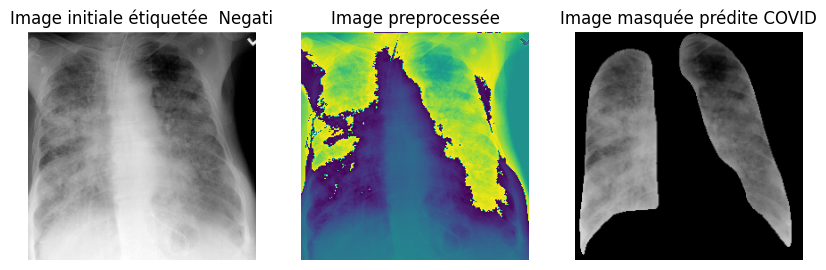

In [194]:
# Visualisation mal étiquetées

for j in range(10):
    i = random.randint(0,len(labels))
    if labels[i] != y_pred[i]:
       
        plt.figure(figsize=(10,5))
        
        plt.subplot(1,3,1)
        plt.imshow(images[i], cmap="gray")
        titre = "Image initiale étiquetée " + " " + y_true[i]
        plt.title(titre)
        plt.axis("off")

        
        plt.subplot(1,3,2)
        plt.imshow(images_scaled[i])
        titre = "Image preprocessée"
        plt.title(titre)
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(masked_images[i])
        titre = "Image masquée prédite" + " " + y_pred[i]
        plt.title(titre)
        plt.axis("off")
        

Test avec le modele MME

In [ ]:
# On charge le modele

clf_model = model = tf.keras.models.load_model("../models/EfficientNetB4_masked-Covid-19_masked-91.45.keras")

